In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d


In [2]:
def load_wav(path):
    audio, sr = sf.read(path)
    return audio.astype(np.float32), sr

def psd_smooth(audio, fs, nperseg=2**14, sigma=2):
    f, Pxx = welch(audio, fs=fs, nperseg=nperseg)
    Pxx_db = 10 * np.log10(Pxx + 1e-10)  # Add small value to avoid log(0)
    return f, gaussian_filter1d(Pxx_db, sigma=sigma)

octave_edges = [20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20000]

def octave_bands(f, psd_db):
    bands = []
    for i in range(len(octave_edges)-1):
        idx = (f >= octave_edges[i]) & (f < octave_edges[i+1])
        if np.any(idx):
            bands.append(np.mean(psd_db[idx]))
        else:
            bands.append(-100)  # Very low value if no data in band
    return np.array(bands)

def cumulative_energy(f, psd_db):
    mask = (f >= 20) & (f <= 20000)
    f2 = f[mask]
    psd_lin = 10**(psd_db[mask]/10)
    cum = np.cumsum(psd_lin)
    if cum[-1] > 0:
        return f2, cum / cum[-1]
    else:
        return f2, cum


Before: shape=(720000,), sr=48000
After: shape=(720000,), sr=48000


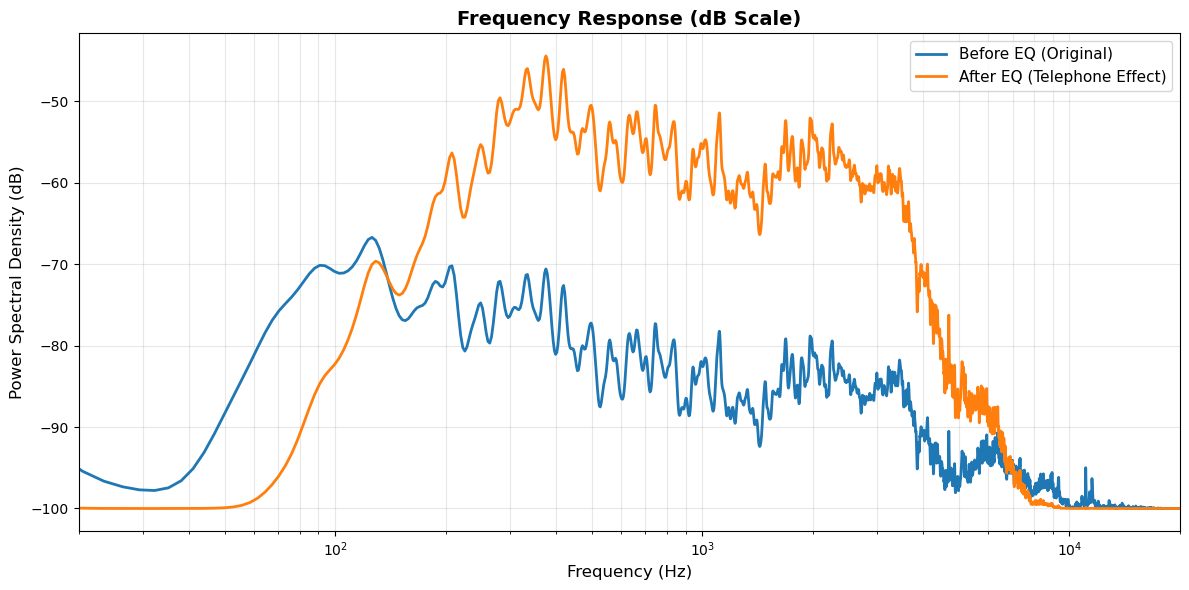

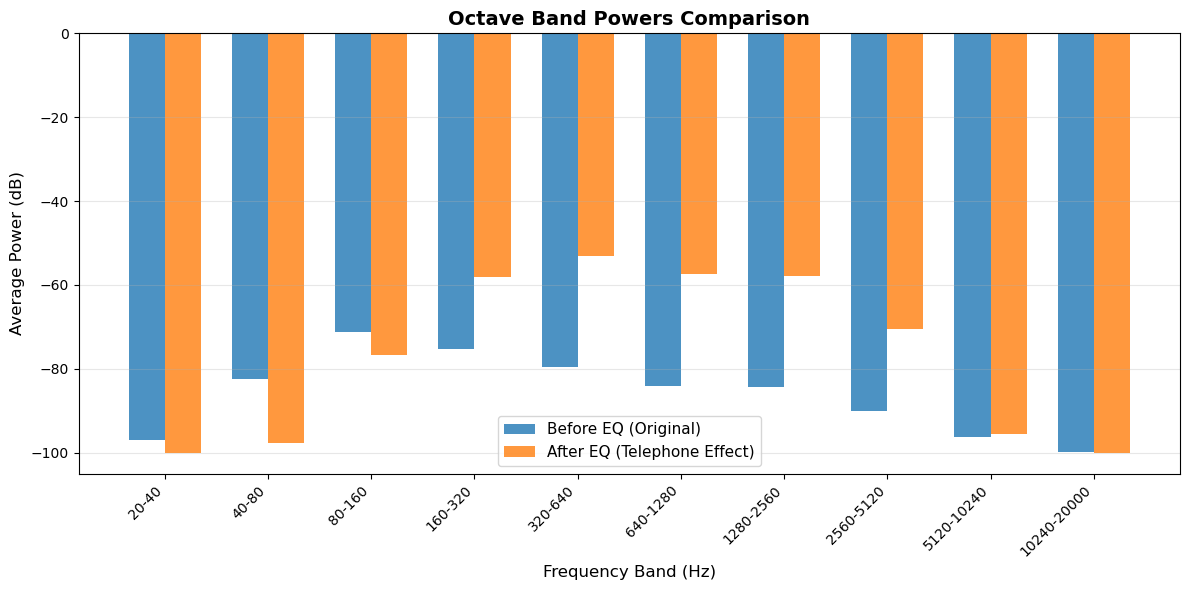

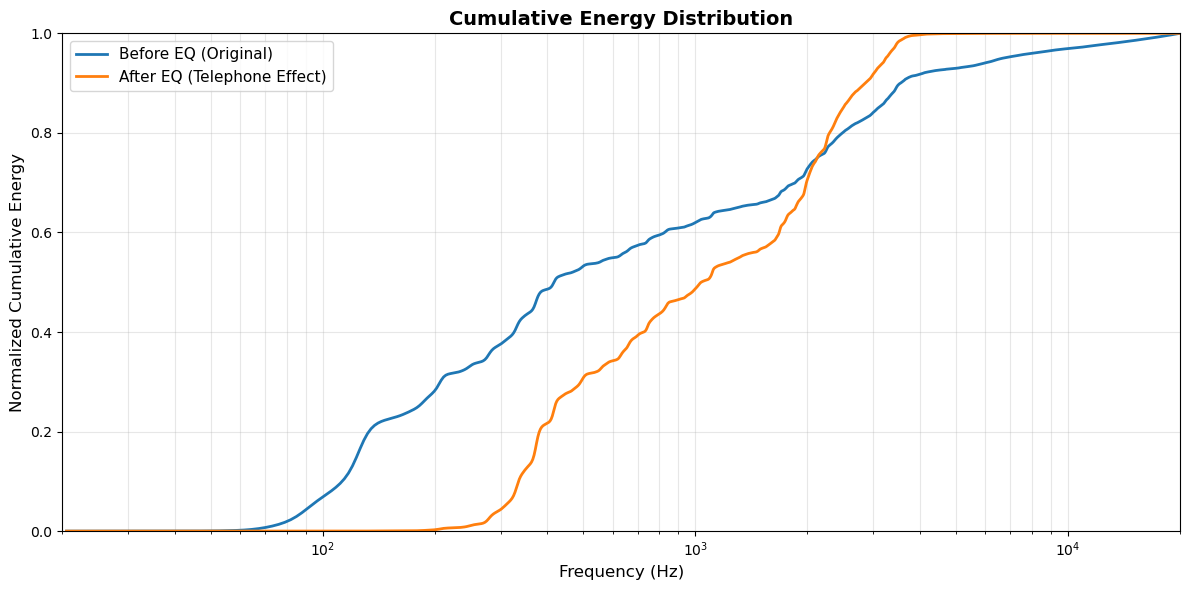

In [3]:

# Load the original and filtered audio files
wavfile_before = "data/recorded_sample_mono.wav"
wavfile_after = "data/telephone_effect.wav"

audio_before, fs_before = load_wav(wavfile_before)
audio_after, fs_after = load_wav(wavfile_after)

print(f"Before: shape={audio_before.shape}, sr={fs_before}")
print(f"After: shape={audio_after.shape}, sr={fs_after}")

# Calculate PSDs
f_before, psd_before = psd_smooth(audio_before, fs_before)
f_after, psd_after = psd_smooth(audio_after, fs_after)

# PLOT 1: Frequency Response (Log-X, Linear-Y in dB)
plt.figure(figsize=(12, 6))
plt.semilogx(f_before, psd_before, label="Before EQ (Original)", linewidth=2)
plt.semilogx(f_after, psd_after, label="After EQ (Telephone Effect)", linewidth=2)
plt.grid(True, which="both", alpha=0.3)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power Spectral Density (dB)", fontsize=12)
plt.title("Frequency Response (dB Scale)", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.xlim([20, 20000])
plt.tight_layout()
plt.savefig("plots/freq_response.png")
plt.show()

# PLOT 2: Octave Band Comparison
bands_before = octave_bands(f_before, psd_before)
bands_after = octave_bands(f_after, psd_after)

plt.figure(figsize=(12, 6))
x = np.arange(len(bands_before))
width = 0.35
plt.bar(x - width/2, bands_before, width, label="Before EQ (Original)", alpha=0.8)
plt.bar(x + width/2, bands_after, width, label="After EQ (Telephone Effect)", alpha=0.8)
plt.xticks(x, [f"{octave_edges[i]}-{octave_edges[i+1]}" for i in range(len(octave_edges)-1)], 
           rotation=45, ha='right')
plt.xlabel("Frequency Band (Hz)", fontsize=12)
plt.ylabel("Average Power (dB)", fontsize=12)
plt.title("Octave Band Powers Comparison", fontsize=14, fontweight='bold')
plt.grid(True, axis="y", alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("plots/octave_bands.png")
plt.show()


# PLOT 3: Cumulative Energy
fC_before, CE_before = cumulative_energy(f_before, psd_before)
fC_after, CE_after = cumulative_energy(f_after, psd_after)

plt.figure(figsize=(12, 6))
plt.semilogx(fC_before, CE_before, label="Before EQ (Original)", linewidth=2)
plt.semilogx(fC_after, CE_after, label="After EQ (Telephone Effect)", linewidth=2)
plt.grid(True, which="both", alpha=0.3)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Normalized Cumulative Energy", fontsize=12)
plt.title("Cumulative Energy Distribution", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.xlim([20, 20000])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig("plots/cumulative_energy.png")
plt.show()
